In [ ]:
%pip install scikit-learn seaborn dgl -f https://data.dgl.ai/wheels/torch-2.4/cu124/repo.html

In [1]:
import dgl.nn as dglnn
from dgl import from_networkx
import torch.nn as nn
import torch as th
import torch.nn.functional as F
import dgl.function as fn
from dgl.data.utils import load_graphs
import networkx as nx
import pandas as pd
import socket
import struct
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# data = pd.read_csv('./bot.csv')
import pandas as pd
from glob import glob

# 读取所有 Full5pc 的 CSV（例如 Full5pc_1, Full5pc_2, ...）
files = glob("./bot/UNSW_2018_IoT_Botnet_Final_10_best_Training.csv")
dfs = [pd.read_csv(f) for f in files]
data = pd.concat(dfs, ignore_index=True)

print("总样本数:", len(data))
print("字段:", data.columns.tolist())
print(data['category'].value_counts())  # 看攻击类别分布

总样本数: 2934817
字段: ['pkSeqID', 'proto', 'saddr', 'sport', 'daddr', 'dport', 'seq', 'stddev', 'N_IN_Conn_P_SrcIP', 'min', 'state_number', 'mean', 'N_IN_Conn_P_DstIP', 'drate', 'srate', 'max', 'attack', 'category', 'subcategory']
category
DDoS              1541315
DoS               1320148
Reconnaissance      72919
Normal                370
Theft                  65
Name: count, dtype: int64


In [3]:
print("字段:", data.columns.tolist())
print("Shape: ", data.columns.shape)

字段: ['pkSeqID', 'proto', 'saddr', 'sport', 'daddr', 'dport', 'seq', 'stddev', 'N_IN_Conn_P_SrcIP', 'min', 'state_number', 'mean', 'N_IN_Conn_P_DstIP', 'drate', 'srate', 'max', 'attack', 'category', 'subcategory']
Shape:  (19,)


In [4]:
# data.drop(columns=['sport', 'dport'], inplace=True)

In [5]:
data.category.value_counts()

category
DDoS              1541315
DoS               1320148
Reconnaissance      72919
Normal                370
Theft                  65
Name: count, dtype: int64

In [6]:
le = LabelEncoder()
le.fit_transform(data.category.values)
data['category'] = le.transform(data['category'])

In [7]:
data['category'].value_counts()

category
0    1541315
1    1320148
3      72919
2        370
4         65
Name: count, dtype: int64

In [8]:
le.fit_transform(data.proto.values)
data['proto'] = le.transform(data['proto'])

In [9]:
data['proto'].value_counts()

proto
4    1596819
3    1330598
1       7228
0        166
2          6
Name: count, dtype: int64

In [10]:
data['saddr'] = data.saddr.apply(str)
data['daddr'] = data.daddr.apply(str)

In [11]:
data['saddr'] = data.saddr.apply(lambda x: socket.inet_ntoa(struct.pack('>I', random.randint(0xac100001, 0xac1f0001))))

In [12]:
data = data.reset_index()
data.replace([np.inf, -np.inf], np.nan,inplace = True)

In [13]:
data.fillna(0,inplace = True)

In [14]:
# label_ground_truth = data[["saddr", "daddr","label"]]

In [15]:
data.drop(columns=['index'],inplace=True)

In [16]:
print("字段:", data.columns.tolist())
print("Shape: ", data.columns.shape)

字段: ['pkSeqID', 'proto', 'saddr', 'sport', 'daddr', 'dport', 'seq', 'stddev', 'N_IN_Conn_P_SrcIP', 'min', 'state_number', 'mean', 'N_IN_Conn_P_DstIP', 'drate', 'srate', 'max', 'attack', 'category', 'subcategory']
Shape:  (19,)


In [17]:
data

,pkSeqID,proto,saddr,sport,daddr,dport,seq,stddev,N_IN_Conn_P_SrcIP,min,state_number,mean,N_IN_Conn_P_DstIP,drate,srate,max,attack,category,subcategory
0,3142762,4,172.26.166.60,6551,192.168.100.3,80,251984,1.900363,100,0.000000,4,2.687519,100,0.000000,0.494549,4.031619,1,0,UDP
1,2432264,3,172.23.162.154,5532,192.168.100.3,80,256724,0.078003,38,3.856930,3,3.934927,100,0.000000,0.256493,4.012924,1,0,TCP
2,1976315,3,172.26.89.198,27165,192.168.100.3,80,62921,0.268666,100,2.974100,3,3.341429,100,0.000000,0.294880,3.609205,1,0,TCP
3,1240757,4,172.21.11.230,48719,192.168.100.3,80,99168,1.823185,63,0.000000,4,3.222832,63,0.000000,0.461435,4.942302,1,1,UDP
4,3257991,4,172.16.164.99,22461,192.168.100.3,80,105063,0.822418,100,2.979995,4,3.983222,100,0.000000,1.002999,4.994452,1,0,UDP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2934812,1132803,4,172.19.250.7,56044,192.168.100.5,80,253370,0.016992,100,4.082509,4,4.102515,100,0.000000,0.243473,4.124047,1,1,UDP
2934813,3384621,4,172.27.159.196,21546,192.168.100.3,80,231693,1.922317,100,0.000000,4,2.718527,100,0.000000,0.490800,4.090534,1,0,UDP
2934814,775893,4,172.23.25.189,30897,192.168.100.5,80,158616,2.112228,100,0.000000,4,2.110766,100,0.000000,0.207444,4.332615,1,1,UDP
2934815,443484,3,172.16.121.232,36904,192.168.100.7,80,179855,0.000000,100,0.000000,3,0.000000,100,0.000000,0.162130,0.000000,1,1,TCP


In [18]:
labels = data["category"]
labels

0          0
1          0
2          0
3          1
4          0
          ..
2934812    1
2934813    0
2934814    1
2934815    1
2934816    1
Name: category, Length: 2934817, dtype: int64

In [19]:

features = data.drop(columns=["category", "subcategory"])
features = features.drop(['saddr', 'daddr'], axis=1)
features

,pkSeqID,proto,sport,dport,seq,stddev,N_IN_Conn_P_SrcIP,min,state_number,mean,N_IN_Conn_P_DstIP,drate,srate,max,attack
0,3142762,4,6551,80,251984,1.900363,100,0.000000,4,2.687519,100,0.000000,0.494549,4.031619,1
1,2432264,3,5532,80,256724,0.078003,38,3.856930,3,3.934927,100,0.000000,0.256493,4.012924,1
2,1976315,3,27165,80,62921,0.268666,100,2.974100,3,3.341429,100,0.000000,0.294880,3.609205,1
3,1240757,4,48719,80,99168,1.823185,63,0.000000,4,3.222832,63,0.000000,0.461435,4.942302,1
4,3257991,4,22461,80,105063,0.822418,100,2.979995,4,3.983222,100,0.000000,1.002999,4.994452,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2934812,1132803,4,56044,80,253370,0.016992,100,4.082509,4,4.102515,100,0.000000,0.243473,4.124047,1
2934813,3384621,4,21546,80,231693,1.922317,100,0.000000,4,2.718527,100,0.000000,0.490800,4.090534,1
2934814,775893,4,30897,80,158616,2.112228,100,0.000000,4,2.110766,100,0.000000,0.207444,4.332615,1
2934815,443484,3,36904,80,179855,0.000000,100,0.000000,3,0.000000,100,0.000000,0.162130,0.000000,1


In [20]:
print("字段:", features.columns.tolist())
print("Shape: ", features.columns.shape)

字段: ['pkSeqID', 'proto', 'sport', 'dport', 'seq', 'stddev', 'N_IN_Conn_P_SrcIP', 'min', 'state_number', 'mean', 'N_IN_Conn_P_DstIP', 'drate', 'srate', 'max', 'attack']
Shape:  (15,)


In [21]:
features.columns

Index(['pkSeqID', 'proto', 'sport', 'dport', 'seq', 'stddev',
       'N_IN_Conn_P_SrcIP', 'min', 'state_number', 'mean', 'N_IN_Conn_P_DstIP',
       'drate', 'srate', 'max', 'attack'],
      dtype='object')

In [22]:
num_features = features.select_dtypes(include=[np.number])
features_array = num_features.values.astype(np.float32)

# features_array = features.values.astype(np.float32)
labels_array = labels.values.astype(np.int64)  # 如果标签是整数型，可以使用 np.long 类型

In [23]:
features_array.shape

(2934817, 13)

In [24]:
labels_array.shape

(2934817,)

In [25]:
scaler = StandardScaler()
standardized_data = scaler.fit_transform(features_array)
min_max_scaler = MinMaxScaler()
normalized_data = min_max_scaler.fit_transform(standardized_data)

In [26]:
import torch
features_tensor = torch.tensor(normalized_data, dtype=torch.float32)
labels_tensor = torch.tensor(labels_array, dtype=torch.long)  # 如果标签是整数型，可以使用 torch.long 类型

In [27]:
features_tensor = pd.concat([data[['saddr', 'daddr']].reset_index(drop=True), pd.DataFrame(features_tensor.numpy())], axis=1)

In [28]:
X_train = features_tensor
y_train = labels_tensor

In [29]:
train_ds = len(X_train)

In [30]:
cols_to_norm = list(set(list(X_train.iloc[:, 2:].columns)) - set(list(['label'])))
X_train[cols_to_norm] = scaler.fit_transform(X_train[cols_to_norm])

In [31]:
X_train['label'] = y_train
X_train['h'] = X_train[cols_to_norm].values.tolist()

In [32]:
X_train

,saddr,daddr,0,1,2,3,4,5,6,7,8,9,10,11,12,label,h
0,172.26.166.60,192.168.100.3,1.235583,0.897328,1.724395,1.261013,0.715453,-0.685658,0.729321,0.301132,0.415178,-0.007652,-0.003357,0.544007,0.011229,0,"[1.2355825901031494, 0.8973283767700195, 1.724..."
1,172.23.162.154,192.168.100.3,0.564705,-1.049143,1.786939,-1.006622,-1.826553,1.914139,-0.113064,1.123003,0.415178,-0.007652,-0.003660,0.533961,0.011229,0,"[0.5647051334381104, -1.0491434335708618, 1.78..."
2,172.26.89.198,192.168.100.3,0.134182,-1.049143,-0.770268,-0.769373,0.715453,1.319060,-0.113064,0.731969,0.415178,-0.007652,-0.003612,0.317014,0.011229,0,"[0.13418172299861908, -1.0491434335708618, -0...."
3,172.21.11.230,192.168.100.3,-0.560358,0.897328,-0.291994,1.164977,-0.801551,-0.685658,0.729321,0.653830,-1.621537,-0.007652,-0.003399,1.033381,0.011229,1,"[-0.5603584051132202, 0.8973283767700195, -0.2..."
4,172.16.164.99,192.168.100.3,1.344386,0.897328,-0.214210,-0.080317,0.715453,1.323033,0.729321,1.154823,0.415178,-0.007652,-0.002709,1.061404,0.011229,0,"[1.3443859815597534, 0.8973283767700195, -0.21..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2934812,172.19.250.7,192.168.100.5,-0.662292,0.897328,1.742683,-1.082541,0.715453,2.066192,0.729321,1.233421,0.415178,-0.007652,-0.003677,0.593675,0.011229,1,"[-0.6622923612594604, 0.8973283767700195, 1.74..."
2934813,172.27.159.196,192.168.100.3,1.463955,0.897328,1.456657,1.288331,0.715453,-0.685658,0.729321,0.321562,0.415178,-0.007652,-0.003362,0.575666,0.011229,0,"[1.4639545679092407, 0.8973283767700195, 1.456..."
2934814,172.23.25.189,192.168.100.5,-0.999300,0.897328,0.492415,1.524645,0.715453,-0.685658,0.729321,-0.078869,0.415178,-0.007652,-0.003723,0.705753,0.011229,1,"[-0.9992995858192444, 0.8973283767700195, 0.49..."
2934815,172.16.121.232,192.168.100.7,-1.313172,-1.049143,0.772662,-1.103685,0.715453,-0.685658,-0.113064,-1.469575,0.415178,-0.007652,-0.003781,-1.622465,0.011229,1,"[-1.3131719827651978, -1.0491434335708618, 0.7..."


In [33]:
from dgl.data.utils import load_graphs   
G = load_graphs("./data.bin")[0][0]

In [ ]:
G = nx.from_pandas_edgelist(X_train, "saddr", "daddr", ['h', 'label'], create_using=nx.MultiGraph())
G = G.to_directed()
G = from_networkx(G, edge_attrs=['h', 'label'])

In [ ]:
# Eq1
G.ndata['h'] = th.ones(G.num_nodes(), G.edata['h'].shape[1])
G.ndata['h'] = th.reshape(G.ndata['h'], (G.ndata['h'].shape[0], 1, G.ndata['h'].shape[1]))
G.edata['h'] = th.reshape(G.edata['h'], (G.edata['h'].shape[0], 1, G.edata['h'].shape[1]))

In [ ]:
G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype=th.bool)

In [ ]:
# from dgl.data.utils import save_graphs
# save_graphs("./data.bin", [G])

In [34]:
node_features = G.ndata['h']
edge_features = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

print(node_features.shape)
print(edge_features.shape)

torch.Size([933626, 1, 13])
torch.Size([5869634, 1, 13])


In [47]:
import torch
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import dgl.function as fn
class SAGELayer(nn.Module):
    # ndim_in, edims 是初始输入的维度，但只有 W_msg111 仍使用 edims
    # ndim_out 是本层最终输出的特征维度 (即 128)
    def __init__(self, ndim_in, edims, ndim_out, activation):
        super(SAGELayer, self).__init__()
        
        # W_msg111：第一次聚合，输入edims (13)，输出ndim_out (128)
        self.W_msg111 = nn.Linear(edims, ndim_out)
        
        # --- 核心修复：第二次聚合 W_msg ---
        # 输入： 第一次聚合后的节点特征 (ndim_out=128) + 原始边特征 (edims=13)
        # 修复为： 128 + 13 = 141
        self.W_msg = nn.Linear(ndim_out + edims, ndim_out) # 141 -> 128
        
        # W_apply：接收 ndim_out 维度输入 (h_neigh + h_neigh)，输出 ndim_out
        self.W_apply = nn.Linear(ndim_out, ndim_out)
        
        self.activation = activation

    def message_func(self, edges):
        # 修正维度：[B, 1, F] -> [B, F]
        src_h = edges.src['h'].squeeze(1)
        edge_h = edges.data['h'].squeeze(1)
        concatenated = th.cat([src_h, edge_h], dim=1) 
        # 消息 m 的维度是 ndim_out
        return {'m': self.W_msg(concatenated).unsqueeze(1)} 

    def message_func111(self, edges):
        # 修正维度：[B, 1, F] -> [B, F]
        edge_h = edges.data['h'].squeeze(1)
        # 原始思想：th.add(edges.data['h'], edges.data['h'])，维度不变
        added = th.add(edge_h, edge_h)
        # 消息 m 的维度是 ndim_out
        return {'m': self.W_msg111(added).unsqueeze(1)}
    def forward(self, g_dgl, nfeats, efeats):
        with g_dgl.local_scope():
            g = g_dgl
            # 节点 h 初始为 [N, 1, ndim_in=13]
            g.ndata['h'] = nfeats
            g.edata['h'] = efeats

            # 第一次聚合：将 h 变为 [N, 1, ndim_out=128]
            g.update_all(self.message_func111, fn.mean('m', 'h_neigh'))
            g.ndata['h'] = F.relu(g.ndata['h_neigh']) # h 现在是 128 维

            # 第二次聚合：使用 128 维的源节点特征和 13 维的边特征
            # 拼接维度：128 + 13 = 141 (与 W_msg 匹配)
            g.update_all(self.message_func, fn.mean('m', 'h_neigh'))

            h_neigh = g.ndata['h_neigh'] 
            aaa = th.add(h_neigh, h_neigh)
            
            aaa_squeezed = aaa.squeeze(1) 
            g.ndata['h'] = F.relu(self.W_apply(aaa_squeezed)).unsqueeze(1)

            return g.ndata['h']

In [48]:
# --- 2. SAGE (Simplified, Coordinating Block) ---
class SAGE(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super(SAGE, self).__init__()
        self.layers = nn.ModuleList()
        # GNN 层输出 ndim_out 维特征
        self.layers.append(SAGELayer(ndim_in, edim, ndim_out, activation))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, g, nfeats, efeats):
        for i, layer in enumerate(self.layers):
            if i != 0:
                nfeats = self.dropout(nfeats)
            nfeats = layer(g, nfeats, efeats)
            
        # 原始思想：nfeats.sum(1)
        # 结果：[N, 1, ndim_out] -> [N, ndim_out]
        return nfeats.sum(1)

In [49]:
# --- 3. FullyConnectedPredictor (Flexible + Original Logic) ---
class FullyConnectedPredictor(nn.Module):
    # in_features 是 GNN 输出特征维度 (ndim_out)
    # edge_dim 是原始边特征维度
    def __init__(self, in_features, out_classes, edge_dim):
        super().__init__()
        
        # --- 原始思想 1：fc111 (边特征转换) ---
        # 原始是 (32 -> 128)。现在是 (edge_dim -> in_features)
        self.fc_edge = nn.Linear(edge_dim, in_features)
        
        # --- 原始思想 2：fc (最终预测层) ---
        # 原始输入是 (h_u + h_v)[in_features] + 转换后的边特征[in_features]，总维度 2 * in_features
        self.fc = nn.Linear(2 * in_features, out_classes) 

    def apply_edges(self, edges):
        # 节点特征 h_u 和 h_v 形状为 [B, in_features]
        h_u = edges.src['h']
        h_v = edges.dst['h']
        
        # --- 原始思想：节点特征乘以 10 并相加 ---
        h_u_scaled = h_u * 10
        h_v_scaled = h_v * 10
        concatenated = th.add(h_u_scaled, h_v_scaled) # [B, in_features]
        
        # 边特征处理
        h_e_raw = edges.data['h'].squeeze(1) # [B, edge_dim]
        h_e_transformed = self.fc_edge(h_e_raw) # [B, in_features]
        
        # 最终拼接： [h_u * 10 + h_v * 10] + [h_e_transformed]
        concatenated = th.cat([concatenated, h_e_transformed], 1) # [B, 2 * in_features]
        
        # 预测分数
        score = self.fc(concatenated) # [B, out_classes]
        return {'score': score}

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [50]:
# --- 4. Model Class (Adapted for New Predictor) ---
class Model(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout, num_classes):
        super().__init__()
        # GNN 块使用 ndim_out 作为其输出维度
        self.gnn = SAGE(ndim_in, ndim_out, edim, activation, dropout) 
        
        # 预测器现在接收 in_features (ndim_out), out_classes, 和 edge_dim (edim)
        self.pred = FullyConnectedPredictor(ndim_out, num_classes, edim) 

    def forward(self, g, nfeats, efeats):
        h = self.gnn(g, nfeats, efeats)
        return self.pred(g, h)

In [39]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(G.edata['label'].cpu().numpy()),
                                                  y=G.edata['label'].cpu().numpy())

class_weights = th.FloatTensor(class_weights)
criterion = nn.CrossEntropyLoss().cuda()
# criterion = nn.CrossEntropyLoss(weight=class_weights).cuda()

In [40]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

In [41]:
node_features = node_features.cuda()
edge_features = edge_features.cuda()
edge_label = edge_label.cuda()
train_mask = train_mask.cuda()
G = G.to('cuda')

In [44]:
print(f"Node feature shape: {node_features.shape}")
print(f"Edge feature shape: {edge_features.shape}")

# 假设输出是:
# Node feature shape: [N, 1, A]  -> A是实际的节点维度
# Edge feature shape: [E, 1, B]  -> B是实际的边的维度

A_actual = node_features.shape[2] # 实际节点维度
B_actual = edge_features.shape[2] # 实际边维度

Node feature shape: torch.Size([933626, 1, 13])
Edge feature shape: torch.Size([5869634, 1, 13])


In [45]:
# 获取实际的特征维度
actual_node_dim = node_features.shape[2] 
actual_edge_dim = edge_features.shape[2] 

In [46]:
# 定义 GNN 的输入/输出维度
node_in_dim = actual_node_dim # 应该等于某个值 A_actual
edge_in_dim = actual_edge_dim # 应该等于某个值 B_actual
gnn_out_dim = 128            
num_classes = 5
print(f"Node In Dim: {actual_node_dim}")
print(f"Edge In Dim: {actual_edge_dim}")

Node In Dim: 13
Edge In Dim: 13


In [51]:
# 实例化模型
model = Model(
    ndim_in=node_in_dim, 
    ndim_out=gnn_out_dim, 
    edim=edge_in_dim, 
    activation=F.relu, 
    dropout=0.2,
    num_classes=num_classes
).to('cuda')

# 优化器
opt = th.optim.Adam(model.parameters())

# 训练循环 (保持不变)
losses = []
accuracies = []

for epoch in range(1, 100):
    pred = model(G, node_features, edge_features)
    loss = criterion(pred[train_mask], edge_label[train_mask])
    opt.zero_grad()
    loss.backward()
    opt.step()

    # 记录损失和准确率
    losses.append(loss.item())
    acc = compute_accuracy(pred[train_mask], edge_label[train_mask])
    accuracies.append(acc)

    if epoch % 1 == 0:
        # if epoch % 100 == 0:
        #     th.save(model.state_dict(), os.path.join('./model', 'epoch-{}.pt'.format(epoch)))
        print('Epoch:', epoch, ' Training acc:', compute_accuracy(pred[train_mask], edge_label[train_mask]))


/tmp/ipykernel_10389/3643900901.py:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1720538435607/work/aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(pred[train_mask], edge_label[train_mask])
/opt/conda/lib/python3.11/site-packages/torch/autograd/graph.py:768: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1720538435607/work/aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/tmp/ipykernel_10389/3643900901.py:27: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1720538435607/work/aten/src/ATen/native/IndexingUtils.h:27.)
  acc = compute_accuracy(pred[trai

Epoch: 1  Training acc: 0.2039261758327484
Epoch: 2  Training acc: 0.6771519780158997
Epoch: 3  Training acc: 0.7730908393859863
Epoch: 4  Training acc: 0.8165943622589111
Epoch: 5  Training acc: 0.8509805202484131
Epoch: 6  Training acc: 0.8578460216522217
Epoch: 7  Training acc: 0.8579837083816528
Epoch: 8  Training acc: 0.8502724766731262
Epoch: 9  Training acc: 0.841496467590332
Epoch: 10  Training acc: 0.8453900814056396
Epoch: 11  Training acc: 0.8601987957954407
Epoch: 12  Training acc: 0.8698767423629761
Epoch: 13  Training acc: 0.8742460012435913
Epoch: 14  Training acc: 0.8773555755615234
Epoch: 15  Training acc: 0.8802096247673035
Epoch: 16  Training acc: 0.8830956220626831
Epoch: 17  Training acc: 0.8889293670654297
Epoch: 18  Training acc: 0.896134614944458
Epoch: 19  Training acc: 0.9006398320198059
Epoch: 20  Training acc: 0.9044499397277832
Epoch: 21  Training acc: 0.9109992384910583
Epoch: 22  Training acc: 0.9174000024795532
Epoch: 23  Training acc: 0.9226531386375427

In [52]:
import torch as th
import os

# 定义保存路径
MODEL_DIR = './saved_models'
MODEL_NAME = 'edge_predictor_sage_final.pt'
SAVE_PATH = os.path.join(MODEL_DIR, MODEL_NAME)

In [53]:


# 确保目录存在
os.makedirs(MODEL_DIR, exist_ok=True)

# 保存模型的状态字典
# model 是您训练好的 Model 实例
th.save(model.state_dict(), SAVE_PATH)

print(f"模型已成功保存到: {SAVE_PATH}")

模型已成功保存到: ./saved_models/edge_predictor_sage_final.pt


In [54]:
# data = pd.read_csv('./bot.csv')
import pandas as pd
from glob import glob

# 读取所有 Full5pc 的 CSV（例如 Full5pc_1, Full5pc_2, ...）
test_files = glob("./bot/UNSW_2018_IoT_Botnet_Final_10_best_Testing.csv")
test_dfs = [pd.read_csv(f) for f in test_files]
test_data = pd.concat(test_dfs, ignore_index=True)

print("总样本数:", len(test_data))
print("字段:", test_data.columns.tolist())
print(test_data['category'].value_counts())  # 看攻击类别分布

总样本数: 733705
字段: ['pkSeqID', 'proto', 'saddr', 'sport', 'daddr', 'dport', 'seq', 'stddev', 'N_IN_Conn_P_SrcIP', 'min', 'state_number', 'mean', 'N_IN_Conn_P_DstIP', 'drate', 'srate', 'max', 'attack', 'category', 'subcategory']
category
DDoS              385309
DoS               330112
Reconnaissance     18163
Normal               107
Theft                 14
Name: count, dtype: int64


In [55]:
le = LabelEncoder()
le.fit_transform(test_data.category.values)
test_data['category'] = le.transform(test_data['category'])

In [56]:
le.fit_transform(test_data.proto.values)
test_data['proto'] = le.transform(test_data['proto'])

In [57]:
test_data['saddr'] = test_data.saddr.apply(str)
test_data['daddr'] = test_data.daddr.apply(str)

In [58]:
test_data['saddr'] = test_data.saddr.apply(lambda x: socket.inet_ntoa(struct.pack('>I', random.randint(0xac100001, 0xac1f0001))))

In [59]:
test_data = test_data.reset_index()
test_data.replace([np.inf, -np.inf], np.nan,inplace = True)

In [60]:
test_data.fillna(0,inplace = True)

In [61]:
test_data.drop(columns=['index'],inplace=True)

In [62]:
print("字段:", test_data.columns.tolist())
print("Shape: ", test_data.columns.shape)

字段: ['pkSeqID', 'proto', 'saddr', 'sport', 'daddr', 'dport', 'seq', 'stddev', 'N_IN_Conn_P_SrcIP', 'min', 'state_number', 'mean', 'N_IN_Conn_P_DstIP', 'drate', 'srate', 'max', 'attack', 'category', 'subcategory']
Shape:  (19,)


In [ ]:
test_features = test_data.drop(columns=["category", "subcategory"])
test_features = test_features.drop(['saddr', 'daddr'], axis=1)
test_features

In [ ]:
test_labels = test_data["category"]
test_labels

In [ ]:
test_num_features = test_features.select_dtypes(include=[np.number])
test_features_array = test_num_features.values.astype(np.float32)

# features_array = features.values.astype(np.float32)
test_labels_array = test_labels.values.astype(np.int64)  # 如果标签是整数型，可以使用 np.long 类型

In [ ]:
test_features_array.shape

In [ ]:
test_labels_array.shape

In [ ]:
scaler = StandardScaler()
test_standardized_data = scaler.fit_transform(test_features_array)
min_max_scaler = MinMaxScaler()
test_normalized_data = min_max_scaler.fit_transform(test_standardized_data)

In [ ]:
import torch
test_features_tensor = torch.tensor(test_normalized_data, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels_array, dtype=torch.long)  # 如果标签是整数型，可以使用 torch.long 类型

In [ ]:
test_features_tensor = pd.concat([test_data[['saddr', 'daddr']].reset_index(drop=True), pd.DataFrame(test_features_tensor.numpy())], axis=1)

In [ ]:
X_test = test_features_tensor
y_test = test_labels_tensor

In [ ]:
test_ds = len(X_test)

In [ ]:
test_cols_to_norm = list(set(list(X_test.iloc[:, 2:].columns)) - set(list(['label'])))
X_test[test_cols_to_norm] = scaler.fit_transform(X_test[test_cols_to_norm])

In [ ]:
X_test['label'] = y_test
X_test['h'] = X_test[test_cols_to_norm].values.tolist()

In [ ]:
X_test

In [63]:
from dgl.data.utils import load_graphs   
G_Test = load_graphs("./test_data.bin")[0][0]

In [ ]:
G_Test = nx.from_pandas_edgelist(X_test, "saddr", "daddr", ['h', 'label'], create_using=nx.MultiGraph())
G_Test = G_Test.to_directed()
G_Test = from_networkx(G_Test, edge_attrs=['h', 'label'])

In [ ]:
# Eq1
G_Test.ndata['h'] = th.ones(G_Test.num_nodes(), G_Test.edata['h'].shape[1])
G_Test.ndata['h'] = th.reshape(G_Test.ndata['h'], (G_Test.ndata['h'].shape[0], 1, G_Test.ndata['h'].shape[1]))
G_Test.edata['h'] = th.reshape(G_Test.edata['h'], (G_Test.edata['h'].shape[0], 1, G_Test.edata['h'].shape[1]))

In [ ]:
G_Test.edata['test_mask'] = th.ones(len(G_Test.edata['h']), dtype=th.bool)

In [ ]:
# from dgl.data.utils import save_graphs
# save_graphs("./test_data.bin", [G_Test])

In [64]:
test_node_features = G_Test.ndata['h'].cuda()
test_edge_features = G_Test.edata['h'].cuda()

test_edge_label = G_Test.edata['label']
test_mask = G_Test.edata['test_mask']

print(test_node_features.shape)
print(test_edge_features.shape)

torch.Size([517147, 1, 13])
torch.Size([1467410, 1, 13])


In [65]:
actual = G_Test.edata.pop('label')

In [66]:
# 假设您已经定义了 Model 类和所有必要的参数

# 重新定义模型参数 (必须与保存时一致)
node_in_dim = test_node_features.shape[2] # 假设是 35
edge_in_dim = test_edge_features.shape[2] # 假设是 35
gnn_out_dim = 128
num_classes = 5

# 1. 实例化模型（使用与训练时相同的参数）
loaded_model = Model(
    ndim_in=node_in_dim, 
    ndim_out=gnn_out_dim, 
    edim=edge_in_dim, 
    activation=F.relu, 
    dropout=0.2,
    num_classes=num_classes
).to('cuda')

# 2. 加载状态字典
# 如果模型训练时在 GPU 上，加载到 CPU 或当前设备：
loaded_model.load_state_dict(th.load(SAVE_PATH))

# 3. 将模型设置为评估模式（在进行推理或测试时非常重要）
loaded_model.eval() 

# 4. 如果需要在 GPU 上进行推理，请移动模型
# loaded_model.to('cuda')

/tmp/ipykernel_10389/107044675.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(th.load(SAVE_PATH))


Model(
  (gnn): SAGE(
    (layers): ModuleList(
      (0): SAGELayer(
        (W_msg111): Linear(in_features=13, out_features=128, bias=True)
        (W_msg): Linear(in_features=141, out_features=128, bias=True)
        (W_apply): Linear(in_features=128, out_features=128, bias=True)
      )
    )
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (pred): FullyConnectedPredictor(
    (fc_edge): Linear(in_features=13, out_features=128, bias=True)
    (fc): Linear(in_features=256, out_features=5, bias=True)
  )
)

In [67]:
# X_test[cols_to_norm] = scaler.transform(X_test[cols_to_norm])

# X_test['label'] = y_test
# X_test['h'] = X_test[cols_to_norm].values.tolist()

# G_test = nx.from_pandas_edgelist(X_test, "saddr", "daddr", ['h', 'label'], create_using=nx.MultiGraph())
# G_test = G_test.to_directed()
# G_test = from_networkx(G_test, edge_attrs=['h', 'label'])
# G_test.ndata['feature'] = th.ones(G_test.num_nodes(), G.ndata['h'].shape[2])

# G_test.ndata['feature'] = th.reshape(G_test.ndata['feature'],
#                                      (G_test.ndata['feature'].shape[0], 1, G_test.ndata['feature'].shape[1]))
# G_test.edata['h'] = th.reshape(G_test.edata['h'], (G_test.edata['h'].shape[0], 1, G_test.edata['h'].shape[1]))


In [68]:
import timeit
G_Test = G_Test.to('cuda')
start_time = timeit.default_timer()
# node_features_test = G_Test.ndata['feature'].cuda()
# edge_features_test = G_Test.edata['h'].cuda()
test_pred = loaded_model(G_Test, test_node_features, test_edge_features).to('cuda')
elapsed = timeit.default_timer() - start_time

print(str(elapsed) + ' seconds')

test_pred = test_pred.argmax(1)
test_pred = th.Tensor.cpu(test_pred).detach().numpy()

2.767412011999113 seconds


In [69]:
print("输出混淆矩阵")
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(actual, test_pred)
print(cm)

输出混淆矩阵
[[770126    398      0     94      0]
 [   910 659308      2      4      0]
 [    22      2    190      0      0]
 [  8070      6      0  28250      0]
 [    22      0      0      6      0]]


In [70]:
print("计算评价指标")
import numpy as np
# from tabulate import tabulate

conf_matrix = cm

# 计算评估指标
accuracy = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)
recall_per_class = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
recall = np.mean(recall_per_class)
precision_per_class = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
f1_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class)
class_counts = np.sum(conf_matrix, axis=1)
weighted_f1 = np.sum(f1_per_class * class_counts) / np.sum(class_counts)

table_data = []
for i in range(len(recall_per_class)):
    table_data.append([f"类别 {i}",
                       np.round(np.diag(conf_matrix)[i] / np.sum(conf_matrix[i]), 3),
                       np.round(recall_per_class[i], 3),
                       np.round(precision_per_class[i], 3),
                       np.round(f1_per_class[i], 3)])

table_data.append(["平均", np.round(accuracy, 3), np.round(recall, 3), np.round(np.mean(precision_per_class), 3),
                   np.round(weighted_f1, 3)])

headers = ["类别", "准确率", "召回率", "精确率", "加权平均F1值"]
# print(tabulate(table_data, headers=headers, floatfmt=".3f", tablefmt="pretty", numalign='center'))

print('over')

计算评价指标
over


/tmp/ipykernel_10389/1725162759.py:11: RuntimeWarning: invalid value encountered in divide
  precision_per_class = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)


target_names [0 1 2 3 4]


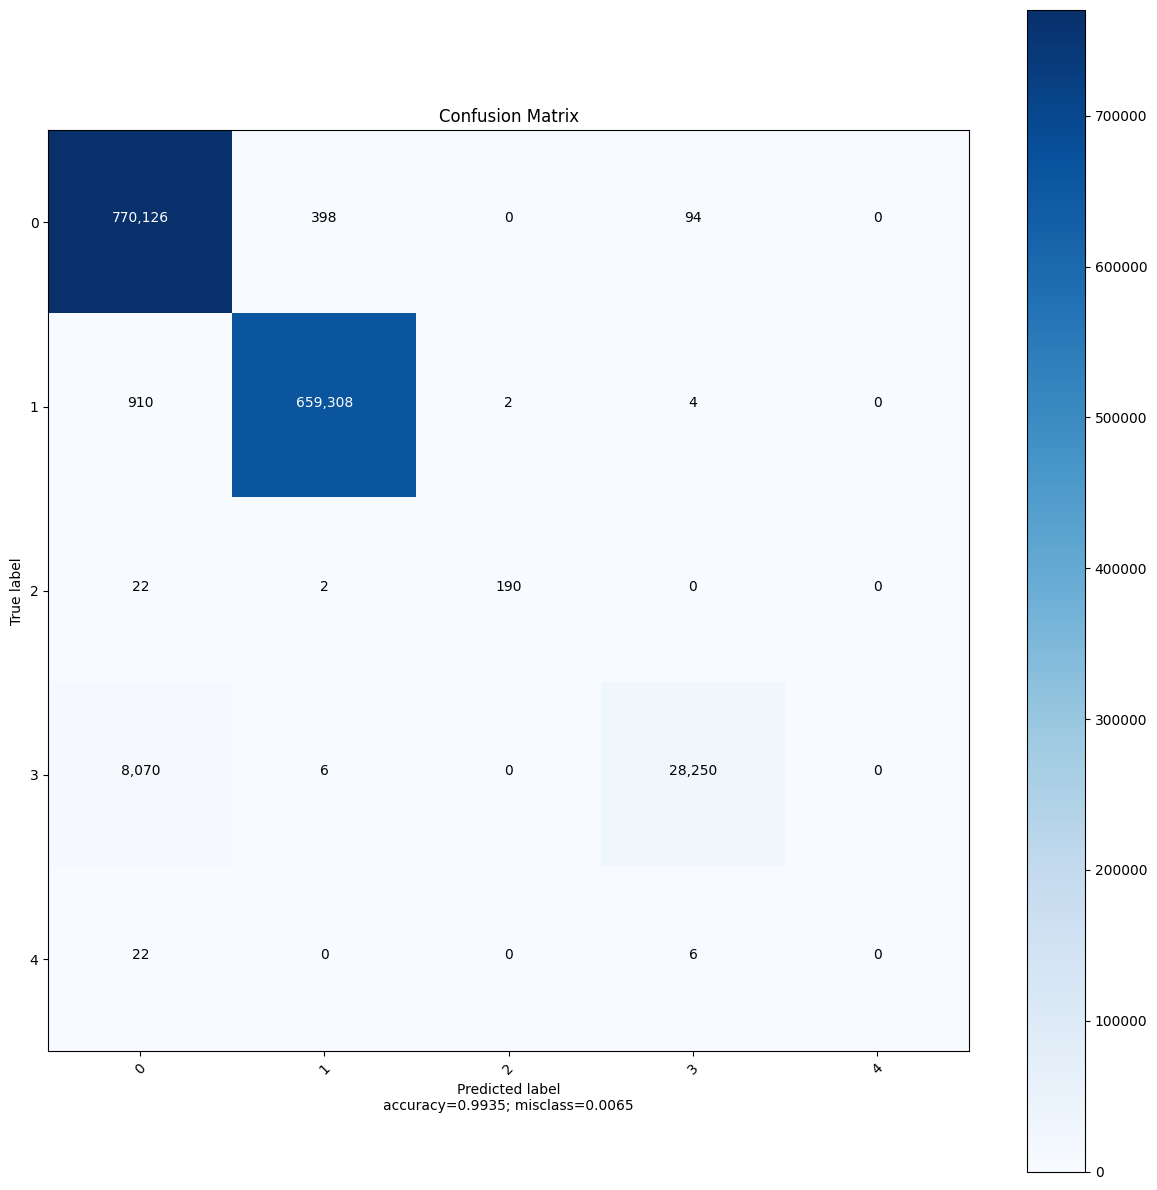

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


              precision    recall  f1-score   support

           0     0.9884    0.9994    0.9939    770618
           1     0.9994    0.9986    0.9990    660224
           2     0.9896    0.8879    0.9360       214
           3     0.9963    0.7777    0.8735     36326
           4     0.0000    0.0000    0.0000        28

    accuracy                         0.9935   1467410
   macro avg     0.7947    0.7327    0.7605   1467410
weighted avg     0.9935    0.9935    0.9932   1467410



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [71]:
import numpy as np
import pandas as pd

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


from sklearn.metrics import confusion_matrix

print("target_names",np.unique(actual))
plot_confusion_matrix(cm=confusion_matrix(actual, test_pred),
                      normalize=False,
                      target_names=np.unique(actual),
                      title="Confusion Matrix")

from sklearn.metrics import classification_report
print(classification_report(actual, test_pred, digits=4))
report = classification_report(actual, test_pred, digits=4, output_dict=True)
df = pd.DataFrame(report).transpose()